# Event Segmentation: Physical Activity Level Transitions

This notebook demonstrates how to query event data from the OCED-mHealth format

## Setup

First, let's set up our environment and import the necessary modules.

In [1]:
import datetime
import sys
# Add the project root directory to the Python path
sys.path.append('..')
from concurrent.futures import ThreadPoolExecutor
from src.oced.oced_data_query import OCEDDataQuery
from src.oced.time_objects import TimeObject

## Query OCED-mHealth Data to Retrieve Sensor Events 

#### 1. Get OCED-mHealth Data from JSON File

In [2]:
dataQuery = OCEDDataQuery()  
oced_data_file = f"oced_data_time.json"
data_dict = dataQuery.load_json(oced_data_file)

#### 2. Get sensor events data by type, filtering time

In [3]:
start_date = datetime.datetime(2025, 5, 11)
end_date = datetime.datetime(2025, 5, 12)

Load accelerometer sensor events

In [4]:
accelerometer_data_df = dataQuery.get_accelerometer_events(data_dict,  start_date=start_date, end_date=end_date) # start_date=start_date, end_date=end_date)
accelerometer_data_df.head()

Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'heartrate', 'location', 'activity_type', 'accelerometer'}
Number of accelerometer events found: 2902004
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:06.728000
  Latest timestamp: 2025-05-14 22:52:11.561000
After start date filtering: 1953612 events remaining
After end date filtering: 621534 events remaining


,timestamp,x,y,z
1950685,2025-05-11 08:44:30.622,-3.931407,5.245068,-7.372287
1950686,2025-05-11 08:44:30.642,-3.986443,5.235496,-7.341179
1950688,2025-05-11 08:44:30.643,-3.850052,5.242674,-7.259824
1950687,2025-05-11 08:44:30.643,-3.964907,5.249853,-7.302894
1950690,2025-05-11 08:44:30.678,-3.852444,5.199604,-7.211967


Load heartrate sensor events

In [5]:
heartrate_data_df = dataQuery.get_heartrate_events(data_dict, start_date=start_date, end_date=end_date)
heartrate_data_df.head()

Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'heartrate', 'location', 'activity_type', 'accelerometer'}
Number of heartrate events found: 1056730
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:26.735000
  Latest timestamp: 2025-05-21 10:55:41.609000
After start date filtering: 888140 events remaining
After end date filtering: 117311 events remaining


,timestamp,bpm,pp
887597,2025-05-11 08:44:46.363,60.0,0.0
887054,2025-05-11 08:44:46.363,60.0,0.0
887598,2025-05-11 08:44:46.444,60.0,0.0
887055,2025-05-11 08:44:46.444,60.0,0.0
887599,2025-05-11 08:44:46.524,60.0,0.0


#### 3. Clean Memory

In [6]:
del data_dict
import gc
gc.collect()  # Force garbage collection

0

#### 4. Validate sensor attribute value distribution

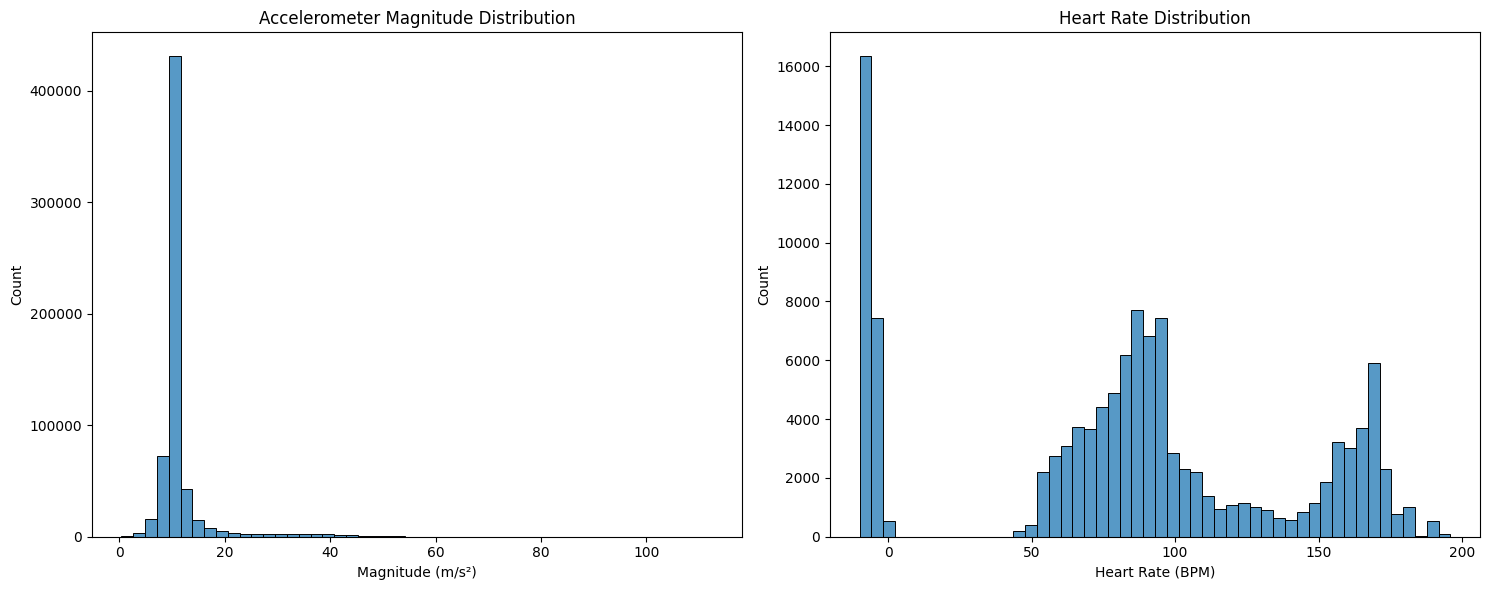


Accelerometer Magnitude Statistics:
Mean: 11.26 m/s²
Std: 5.40 m/s²
Min: 0.38 m/s²
Max: 112.49 m/s²
Median: 10.07 m/s²
Skewness: 4.48
Kurtosis: 23.25

Heart Rate Statistics:
Mean: 83.31 BPM
Std: 57.74 BPM
Min: -10.00 BPM
Max: 196.00 BPM
Median: 86.00 BPM
Skewness: -0.18
Kurtosis: -0.79


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate accelerometer magnitude
accelerometer_magnitude = np.sqrt(
    accelerometer_data_df['x']**2 + 
    accelerometer_data_df['y']**2 + 
    accelerometer_data_df['z']**2
)

# Plot accelerometer distribution
sns.histplot(data=accelerometer_magnitude, ax=ax1, bins=50)
ax1.set_title('Accelerometer Magnitude Distribution')
ax1.set_xlabel('Magnitude (m/s²)')
ax1.set_ylabel('Count')

# Plot heartrate distribution
sns.histplot(data=heartrate_data_df['bpm'], ax=ax2, bins=50)
ax2.set_title('Heart Rate Distribution')
ax2.set_xlabel('Heart Rate (BPM)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nAccelerometer Magnitude Statistics:")
print(f"Mean: {accelerometer_magnitude.mean():.2f} m/s²")
print(f"Std: {accelerometer_magnitude.std():.2f} m/s²")
print(f"Min: {accelerometer_magnitude.min():.2f} m/s²")
print(f"Max: {accelerometer_magnitude.max():.2f} m/s²")
print(f"Median: {np.median(accelerometer_magnitude):.2f} m/s²")
print(f"Skewness: {stats.skew(accelerometer_magnitude):.2f}")
print(f"Kurtosis: {stats.kurtosis(accelerometer_magnitude):.2f}")

print("\nHeart Rate Statistics:")
print(f"Mean: {heartrate_data_df['bpm'].mean():.2f} BPM")
print(f"Std: {heartrate_data_df['bpm'].std():.2f} BPM")
print(f"Min: {heartrate_data_df['bpm'].min():.2f} BPM")
print(f"Max: {heartrate_data_df['bpm'].max():.2f} BPM")
print(f"Median: {heartrate_data_df['bpm'].median():.2f} BPM")
print(f"Skewness: {stats.skew(heartrate_data_df['bpm']):.2f}")
print(f"Kurtosis: {stats.kurtosis(heartrate_data_df['bpm']):.2f}")

## Align Sensor Types 

#### 1. Analyze Time Intervals Between Sensor Events

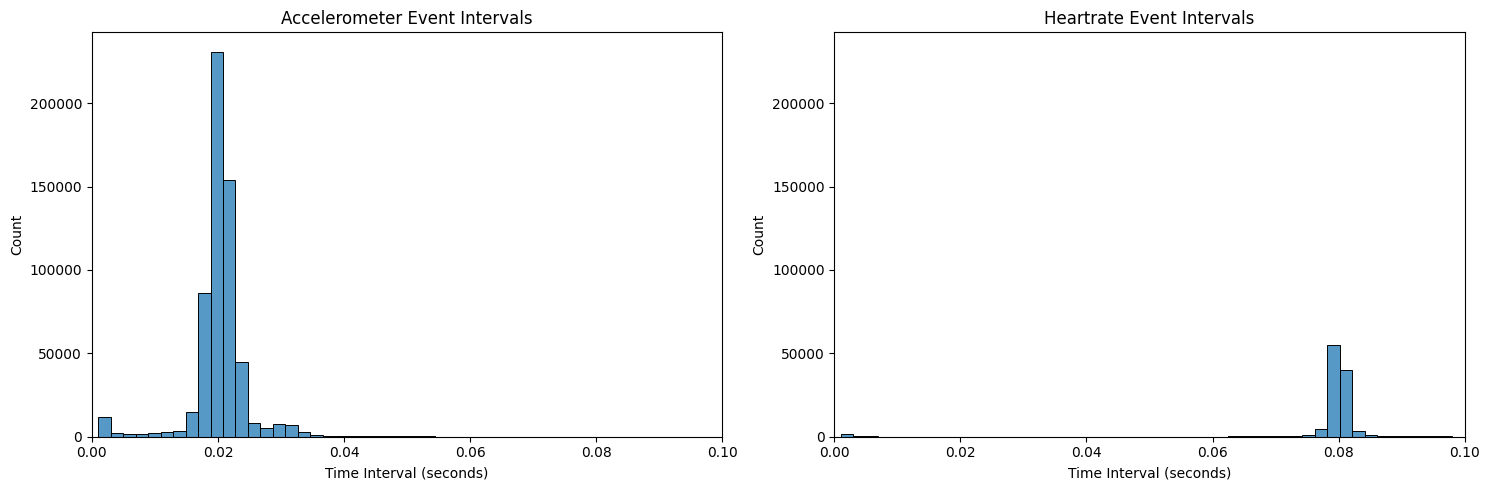


Statistics for Accelerometer intervals (all data):
Total number of intervals: 592,778
Mean interval: 0.087 seconds
Median interval: 0.020 seconds
Standard deviation: 5.748 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1016.301 seconds
95th percentile: 0.026 seconds
99th percentile: 0.036 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 591,540 (99.79%)
Intervals > 0.1 seconds: 1,238 (0.21%)
Intervals > 1 second: 218 (0.04%)
Intervals > 10 seconds: 194 (0.03%)

Statistics for Heartrate intervals (all data):
Total number of intervals: 115,179
Mean interval: 0.450 seconds
Median interval: 0.080 seconds
Standard deviation: 14.018 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1881.523 seconds
95th percentile: 0.083 seconds
99th percentile: 0.129 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 113,284 (98.35%)
Intervals > 0.1 seconds: 1,895 (1.65%)
Intervals > 1 second: 224 (0.19%)
Intervals > 10 seconds: 201 (0.17%)

Gap Analysis for Accelerometer:


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_time_intervals(df):
    """Calculate time intervals between consecutive events in seconds."""
    # Sort by timestamp to ensure correct order
    df = df.sort_values('timestamp')
    # Calculate time differences in seconds
    intervals = df['timestamp'].diff().dt.total_seconds()
    # Remove the first row (NaN) and any negative intervals (shouldn't exist)
    intervals = intervals[intervals > 0]
    return intervals

# Calculate intervals for both sensor types
accel_intervals = calculate_time_intervals(accelerometer_data_df)
hr_intervals = calculate_time_intervals(heartrate_data_df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Filter intervals <= 0.1 seconds for visualization only
accel_filtered = accel_intervals[accel_intervals <= 0.1]
hr_filtered = hr_intervals[hr_intervals <= 0.1]

# Plot histograms without KDE
sns.histplot(data=accel_filtered, bins=50, ax=ax1, kde=False)
ax1.set_title('Accelerometer Event Intervals')
ax1.set_xlabel('Time Interval (seconds)')
ax1.set_ylabel('Count')
ax1.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

sns.histplot(data=hr_filtered, bins=50, ax=ax2, kde=False)
ax2.set_title('Heartrate Event Intervals')
ax2.set_xlabel('Time Interval (seconds)')
ax2.set_ylabel('Count')
ax2.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

# Set the same y-axis limits for both plots
max_count = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, max_count)
ax2.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

# Calculate and print statistics using ALL data points
def print_statistics(intervals, sensor_type):
    print(f"\nStatistics for {sensor_type} intervals (all data):")
    print(f"Total number of intervals: {len(intervals):,}")
    print(f"Mean interval: {intervals.mean():.3f} seconds")
    print(f"Median interval: {intervals.median():.3f} seconds")
    print(f"Standard deviation: {intervals.std():.3f} seconds")
    print(f"Minimum interval: {intervals.min():.3f} seconds")
    print(f"Maximum interval: {intervals.max():.3f} seconds")
    print(f"95th percentile: {np.percentile(intervals, 95):.3f} seconds")
    print(f"99th percentile: {np.percentile(intervals, 99):.3f} seconds")
    
    # Print distribution of intervals
    print(f"\nInterval distribution:")
    print(f"Intervals ≤ 0.1 seconds: {len(intervals[intervals <= 0.1]):,} ({len(intervals[intervals <= 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 0.1 seconds: {len(intervals[intervals > 0.1]):,} ({len(intervals[intervals > 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 1 second: {len(intervals[intervals > 1]):,} ({len(intervals[intervals > 1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 10 seconds: {len(intervals[intervals > 10]):,} ({len(intervals[intervals > 10])/len(intervals)*100:.2f}%)")

print_statistics(accel_intervals, "Accelerometer")
print_statistics(hr_intervals, "Heartrate")

# Additional analysis: Check for gaps in the data
def analyze_gaps(intervals, sensor_type, threshold_seconds=60):
    gaps = intervals[intervals > threshold_seconds]
    print(f"\nGap Analysis for {sensor_type}:")
    print(f"Number of gaps > {threshold_seconds} seconds: {len(gaps):,}")
    if len(gaps) > 0:
        print(f"Largest gap: {gaps.max():.1f} seconds")
        print(f"Average gap duration: {gaps.mean():.1f} seconds")

analyze_gaps(accel_intervals, "Accelerometer")
analyze_gaps(hr_intervals, "Heartrate")

Define the ACTUAL sampling frequency of each sensor type 

In [9]:
acc_sample_f = 1/accel_intervals.median()
hr_sample_f = 1/hr_intervals.median()

#### 2. Synchronize sensors in one DataFrame

Purpose of Interpolation:
<ul>
    <li>We have sensor data (like accelerometer or heart rate) that was sampled at irregular intervals</li>
    <li>We want to create a new df where all sensors have data points at exactly the same timestamps (synchronized)</li>
    <li>For timestamps where we don't have actual sensor readings, we estimate the values using linear interpolation</li>
</ul>

The actual sampling frequencies of the accelerometer and heartrate sensors seem to be 50 Hz and 12.5 Hz.  Studies have show that for physical activity level classification purposes, downsampling to 25 Hz does not significantly impact the robustness of outcomes. [doi: 10.3390/bioengineering12010018.] 
<p> For simplicity we resample the data into alignment with linear interpolation. We downsample the acc to a sampling freq of 25 Hz, and we upsample the hr to 25 Hz. We store sync events with a timestamp and the value of each sensor attribute.

In [10]:
from src.oced.event_abstraction import SensorEventAbstraction

# Initialize and synchronize as before
sensor_abstraction = SensorEventAbstraction(
    accelerometer=accelerometer_data_df,
    heartrate=heartrate_data_df
)

In [11]:
sync_df = sensor_abstraction.synchronize_sensors(sampling_freq=25, max_gap_seconds=10.0)
sync_df.head()


c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\event_abstraction.py:182: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.92889503 -4.03286302 -4.04626298 ... -3.76848766 -3.75648407
 -3.76220076]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sync_df.loc[valid_mask, col_name] = interpolated_values
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\event_abstraction.py:182: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.19992318 6.19920528 6.12801886 ... 6.48038792 6.52530994 6.48865134]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sync_df.loc[valid_mask, col_name] = interpolated_values
c:\Users\20236075\OneDrive 

,accelerometer_x,accelerometer_y,accelerometer_z,heartrate_bpm,heartrate_pp
timestamp,,,,,
2025-05-11 08:44:46.363,-3.928895,6.199923,-6.496394,60.0,0.0
2025-05-11 08:44:46.403,-4.032863,6.199205,-6.479165,60.0,0.0
2025-05-11 08:44:46.443,-4.046263,6.128019,-6.423532,60.0,0.0
2025-05-11 08:44:46.483,-4.187439,6.096912,-6.376872,60.0,0.0
2025-05-11 08:44:46.523,-4.177868,5.929414,-6.168697,60.0,0.0


#### 3. Investigate sync data quality
Reason for large % of invalid data: The method identifies "valid segments" by looking for gaps larger than max_gap_seconds (default 1.0 second).
When it finds a gap larger than max_gap_seconds, it marks ALL data points between the end of one valid segment and the start of the next as invalid.
This means that even if you have 99% of your data with small intervals, a single gap > 1 second will create a large block of invalid data points. 

<p> Important! It seems logical to create create behavior events that represent this invalid data. Alternatively, we can omit these events but not querying them. We can also think about smoothing techniques that omit the shorter invalid periods 

Invalid periods

c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\event_abstraction.py:436: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transitions = np.where(combined_mask.diff().fillna(False))[0]


               start_time                end_time  duration_seconds
0 2025-05-11 08:45:30.003 2025-05-11 08:59:51.203            861.20
1 2025-05-11 09:00:41.403 2025-05-11 09:04:19.443            218.04
2 2025-05-11 09:05:08.563 2025-05-11 09:16:04.883            656.32
3 2025-05-11 09:16:42.923 2025-05-11 09:20:24.963            222.04
4 2025-05-11 09:21:24.723 2025-05-11 09:32:08.083            643.36


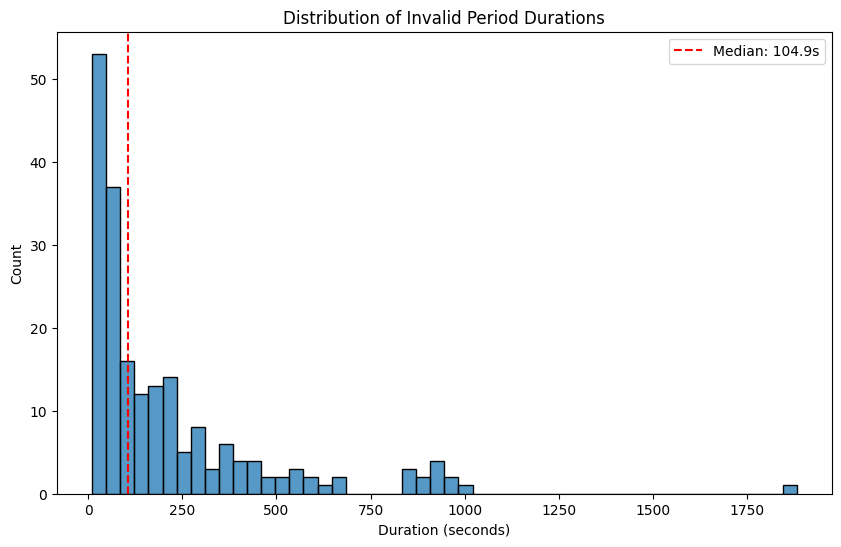


Duration Statistics:
Total periods: 200
Mean duration: 212.5 seconds
Median duration: 104.9 seconds
Max duration: 1881.5 seconds
Min duration: 10.5 seconds
Total duration: 42496.8 seconds


In [12]:
# Get invalid periods for all sensors
invalid_periods_df = sensor_abstraction.get_invalid_periods_df(min_duration_seconds=1.0)

# Display the first few rows
print(invalid_periods_df.head())

def plot_invalid_periods_hist(invalid_periods_df, bins=50, figsize=(10, 6)):
    """
    Plot a histogram of invalid period durations.
    
    Args:
        invalid_periods_df: DataFrame from get_invalid_periods_df()
        bins: Number of histogram bins (default: 50)
        figsize: Figure size tuple (default: (10, 6))
    """
    plt.figure(figsize=figsize)
    
    # Create histogram using seaborn
    sns.histplot(data=invalid_periods_df, x='duration_seconds', bins=bins)
    
    # Customize the plot
    plt.title('Distribution of Invalid Period Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Add a vertical line for the mean
    median_duration = invalid_periods_df['duration_seconds'].median()
    plt.axvline(median_duration, color='red', linestyle='--', 
                label=f'Median: {median_duration:.1f}s')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Print some statistics
    print(f"\nDuration Statistics:")
    print(f"Total periods: {len(invalid_periods_df)}")
    print(f"Mean duration: {invalid_periods_df['duration_seconds'].mean():.1f} seconds")
    print(f"Median duration: {invalid_periods_df['duration_seconds'].median():.1f} seconds")
    print(f"Max duration: {invalid_periods_df['duration_seconds'].max():.1f} seconds")
    print(f"Min duration: {invalid_periods_df['duration_seconds'].min():.1f} seconds")
    print(f"Total duration: {invalid_periods_df['duration_seconds'].sum():.1f} seconds")

plot_invalid_periods_hist(invalid_periods_df)



## Calibrate Accelerometer 

We used the autocalibration method as described in: https://journals.physiology.org/doi/epdf/10.1152/japplphysiol.00421.2014
<p> Because our sesnors are activated when movement is recognized, not a single epoch of 10 seconds would meet the recommeded threshold of 0.013g. Therefore, we increased it to 0.03g. 

In [13]:
from src.oced.acc_calibration import AccelerometerCalibrator

# Define your accelerometer column names
cols = ('accelerometer_x', 'accelerometer_y', 'accelerometer_z')

# Create a calibrator instance
calibrator = AccelerometerCalibrator(axis_cols=cols, fs=25, static_threshold=0.013, unit='m/s2')

# Calibrate the accelerometer data
gains, offsets = calibrator.calibrate(sync_df)


# Apply the calibration
df_calibrated = calibrator.apply_calibration(sync_df)



Static Window Detection Diagnostics:
Total windows analyzed: 932
Windows without invalid values: 933
Windows that passed static test: 103

Standard deviation statistics (in g):
Mean std across all axes: 0.0038
Min std: 0.0015
Max std: 0.0128
Current threshold: 0.0130

Calibration Results (after 50 iterations):
Gains: ['0.9936', '0.9823', '1.0080'] (should be close to 1.0)
Offsets: ['0.0023', '-0.0329', '-0.0065'] (should be close to 0.0)

Calibration Statistics:
Mean magnitude: 1.0000 (should be close to 1.0)
Std magnitude: 0.0026 (should be small)
Gain deviation from 1.0: ['0.0064', '0.0177', '0.0080']
Offset deviation from 0.0: ['0.0023', '0.0329', '0.0065']
Final error: 0.001977
Original data:
                         accelerometer_x  accelerometer_y  accelerometer_z  \
timestamp                                                                    
2025-05-11 08:44:46.363        -3.928895         6.199923        -6.496394   
2025-05-11 08:44:46.403        -4.032863         6.199205  

## Feature Extraction

Reference methods: 
<p>[VM and ANGLE] https://journals.physiology.org/doi/epdf/10.1152/japplphysiol.00026.2015 
<P>[ENMO] DOI: 10.1038/srep45772  

<P>https://www.nature.com/articles/s41598-019-54267-y#:~:text=new%20cut%20points%2C%20we%20found,validated%20using%20data%20from



In [14]:
from src.oced.feature_extraction import FeatureExtractor

# Create a feature extractor with your data
extractor = FeatureExtractor(df_calibrated)
#Identify axis cols
axis_cols=('accelerometer_x', 'accelerometer_y', 'accelerometer_z')

# Accelerometer feature: vector magnitude
vm = extractor.calculate_vector_magnitude(axis_cols=axis_cols, output_col="VM_feature")

# Accelerometer feature: Euclidean Norm Minus One
enmo = extractor.calculate_enmo(axis_cols=axis_cols, output_col='ENMO_feature')

# Accelerometer feature: Acceleration Angle Relative to Vertical
angle = extractor.calculate_vertical_angle(axis_cols=axis_cols, vm_col="VM_feature", output_col='ANGLE_feature')

# Combined feature vector
featured_df = extractor.get_data_with_features()

c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\feature_extraction.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.01179354 1.01480831 1.00706965 ... 0.99391329 0.99742515 0.99447425]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vm.loc[valid_mask] = np.sqrt(squared_sum)
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\feature_extraction.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01179354 0.01480831 0.00706965 ... 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  enmo.loc[valid_mask] = np.maximum(0, magnitude - 1)
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\

## Time-window technique

In [15]:
# Calculate statistics for vector magnitude
vm_stats = extractor.calculate_windowed_statistics(
    window_seconds=5,
    target_col='VM_feature',
    hr_col='heartrate_bpm', 
    stats=['mean', 'std'],
    min_valid_percent=100
)

# Calculate statistics for ENMO
enmo_stats = extractor.calculate_windowed_statistics(
    window_seconds=5,
    target_col='ENMO_feature',
    hr_col='heartrate_bpm', 
    stats=['mean'],
    min_valid_percent=100
)

# Calculate statistics for vertical angle
angle_stats = extractor.calculate_windowed_statistics(
    window_seconds=15,
    target_col='ANGLE_feature',
    hr_col='heartrate_bpm', 
    stats=['mean'],
    min_valid_percent=100
)

## Classification of PA Levels 



### 1. Classification of Light PA and Moderate-Vigorous PA bouts
This classification method is a decision tree with rules: 
<ul>
    <li> Based on an accelerometer feature: mean of the Euclidean Norm Minus One </li>
    <li> Considering invalid (no readings, no wear, errors, etc): invalid accelerometer flag (-9999) and invalid heartrate readings (hr<40)


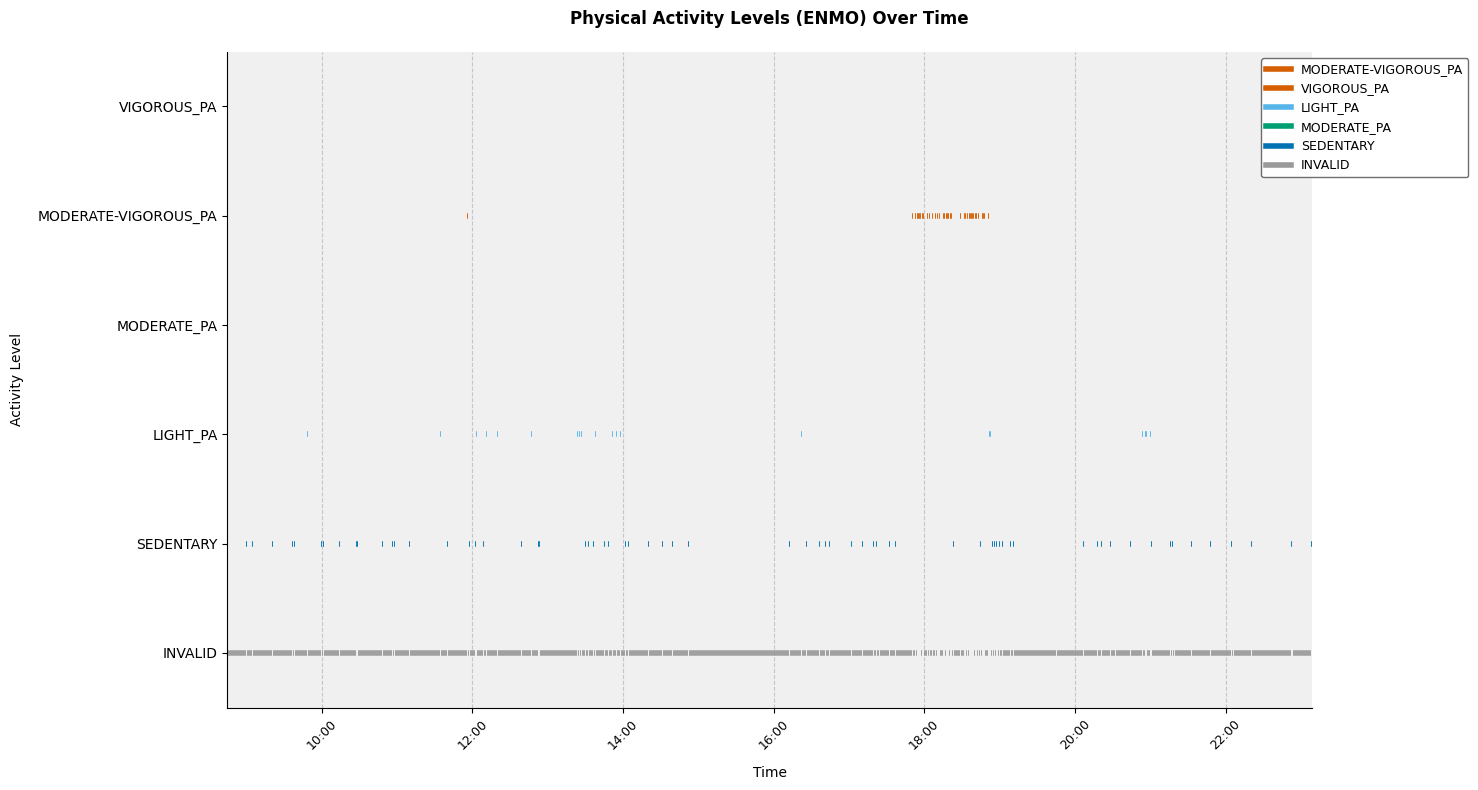

In [16]:
from src.oced.physical_activity_classifier import PhysicalActivityClassifier

# Classify the activity levels
classified_enmo_df = PhysicalActivityClassifier.classify_activity_levels_enmo(enmo_stats, enmo_column='ENMO_feature_mean')

# Then plot the results
PhysicalActivityClassifier.plot_activity_levels_enmo(classified_enmo_df, time_column='window_start', window_end_column='window_end', activity_column='activity_level_enmo')

### 2. Classification of Light, Moderate and Vigorous PA bouts

<ul>
    <li> Based on two accelerometer feature: standard deviation of the Vector Magnitude and mean of the acceleration angle relative to vertical </li>
    <li> Considering invalid (no readings, no wear, errors, etc): invalid accelerometer flag (-9999) and invalid heartrate readings (hr<40)

In [17]:
import pandas as pd
# Combine feature statistics into a single dataframe
vm_stats_subset = vm_stats[['VM_feature_mean', 'VM_feature_std', 'window_start', 'window_end']]
angle_stats_subset = angle_stats[['ANGLE_feature_mean', 'window_start', 'window_end']]
combined_stats = pd.merge(vm_stats_subset, angle_stats_subset, 
                         on=['window_start', 'window_end'], 
                         how='outer')

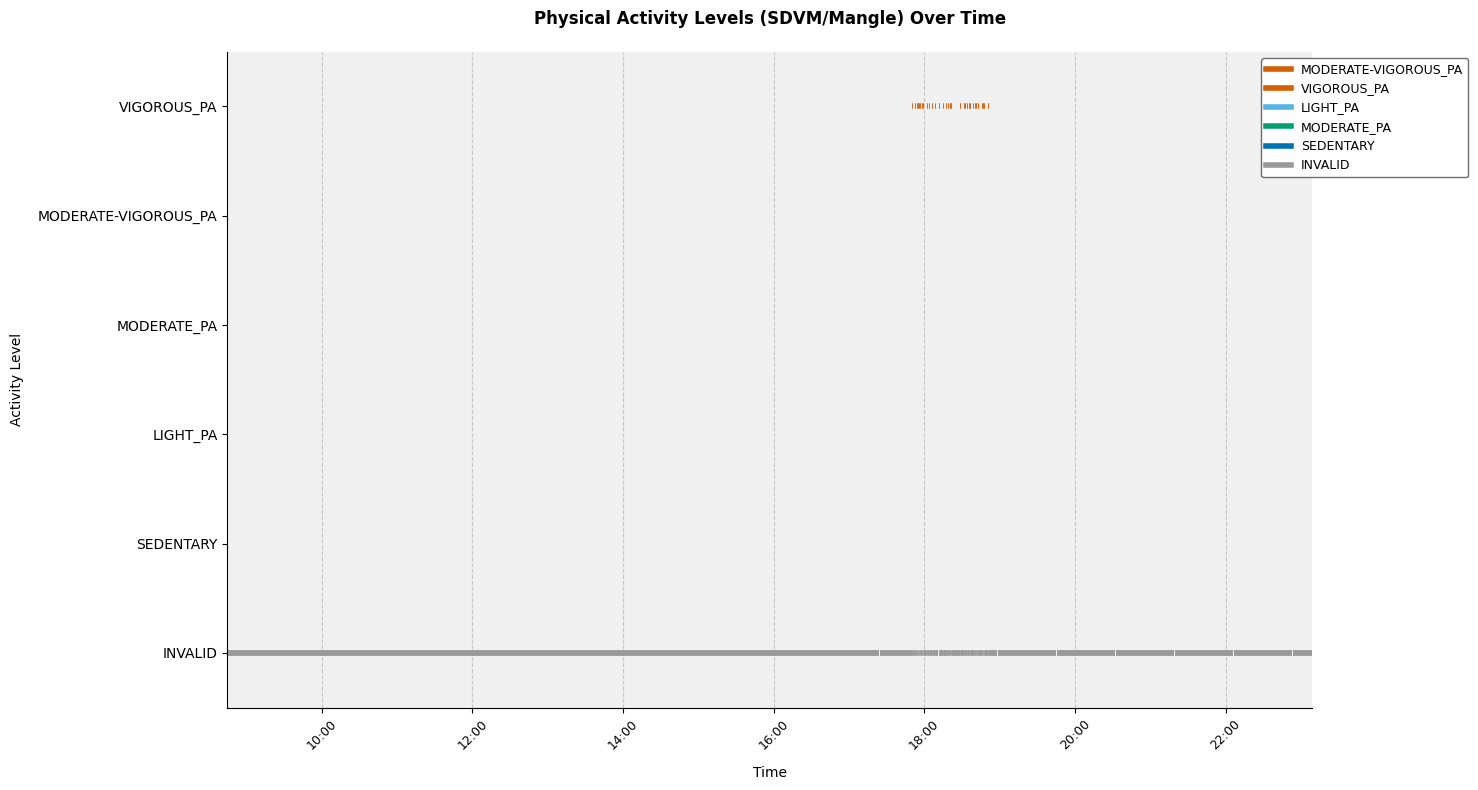

In [18]:
# Classify the activity levels
classified_sdvm_mangle_df = PhysicalActivityClassifier.classify_activity_levels_sdvm_mangle(combined_stats, sdvm_column='VM_feature_std', mangle_column='ANGLE_feature_mean')

# Then plot the results
PhysicalActivityClassifier.plot_activity_levels_sdvm_mangle(classified_sdvm_mangle_df, time_column='window_start', window_end_column='window_end', activity_column='activity_level_sdvm_mangle')

## Smoothing Techniques - Find MVPA bouts / events

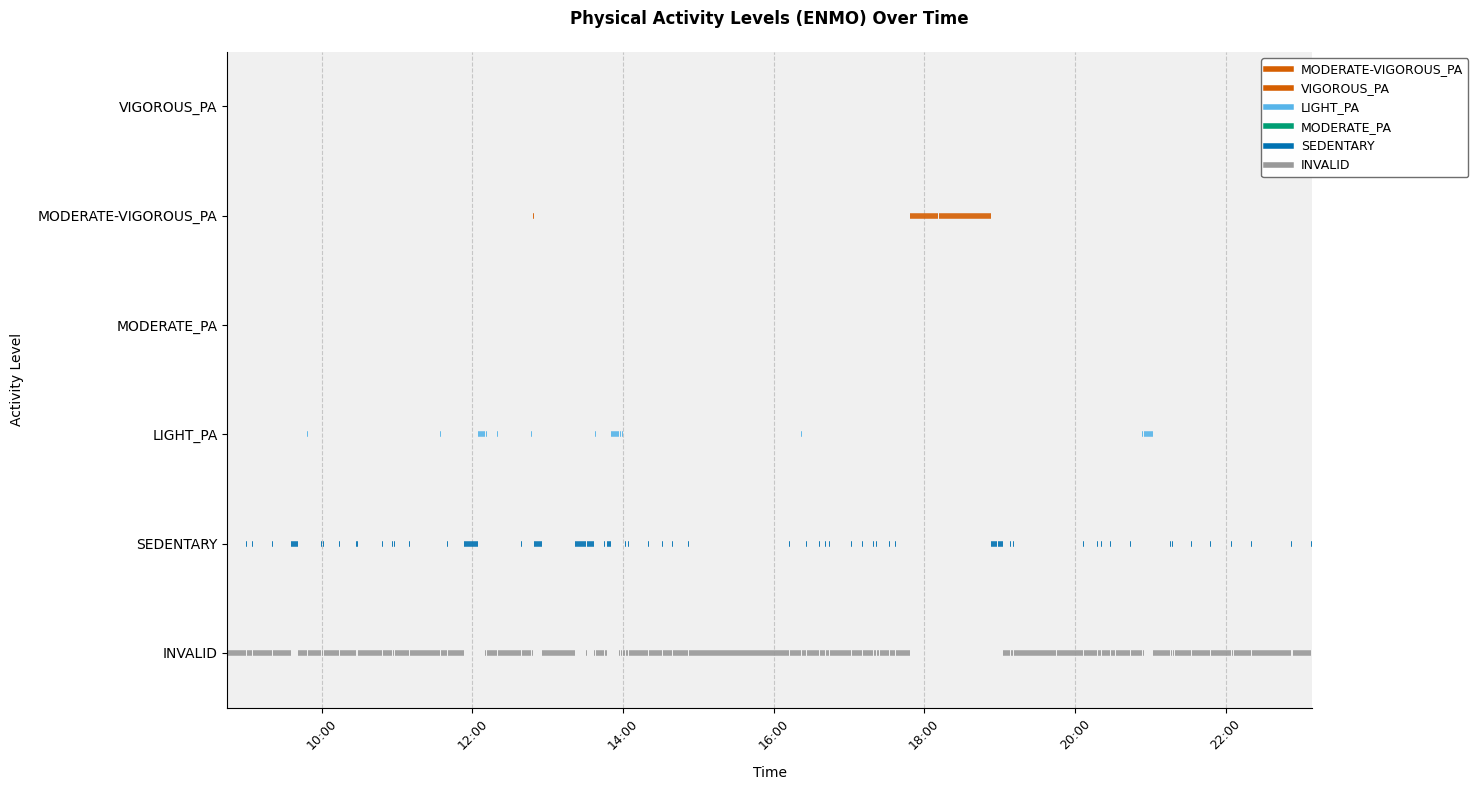

In [19]:
from src.oced.smoothing import SmoothingConfig, SmoothingClassifier

# Create configuration
config = SmoothingConfig(
    window_size=121,   
    invalid_threshold=0.8  
)

# Create classifier
smoother = SmoothingClassifier(config)

# Apply smoothing
smoothed_df = smoother.smooth(
    df=classified_enmo_df,
    class_column='activity_level_enmo',
    start_time_column='window_start',
    end_time_column='window_end'
)

PhysicalActivityClassifier.plot_activity_levels_enmo(smoothed_df, time_column='window_start', window_end_column='window_end', activity_column='smoothed_class')


## Sustained PA Bouts Detection

In [20]:
from src.oced.bout_detection import BoutConfig, BoutDetector

# MVPA BOUTS
# Create configuration for bout detection
MVPA_bout_config = BoutConfig(
    min_duration=pd.Timedelta(minutes=1),  # Minimum 10-minute bouts
    target_class='MODERATE-VIGOROUS_PA',  # Detect moderate activity bouts
    max_invalid_percentage=0.3,  # At most 30% can be invalid values
    min_valid_target_percentage=1,  # Within valid epochs, at least 80% must be target activity
    invalid_class='INVALID'
)
# Create bout detector
MVPA_detector = BoutDetector(MVPA_bout_config)
# Detect bouts from smoothed data
MVPA_bouts_df = MVPA_detector.detect_bouts(
    df=smoothed_df,  # smoothed classification dataframe
    class_column='smoothed_class',
    start_time_column='window_start',
    end_time_column='window_end'
)

#LIGHT PA BOUTS
# Create configuration for bout detection
LIGHT_bout_config = BoutConfig(
    min_duration=pd.Timedelta(minutes=1),  # Minimum 10-minute bouts
    target_class='LIGHT_PA',  # Detect moderate activity bouts
    max_invalid_percentage=0.3,  # At most 30% can be invalid values
    min_valid_target_percentage=0.5,  # Within valid epochs, at least 80% must be target activity
    invalid_class='INVALID'
)
# Create bout detector
LIGHT_detector = BoutDetector(LIGHT_bout_config)
# Detect bouts from smoothed data
LIGHT_bouts_df = LIGHT_detector.detect_bouts(
    df=smoothed_df,  # smoothed classification dataframe
    class_column='smoothed_class',
    start_time_column='window_start',
    end_time_column='window_end'
)

KeyError: 'window_start'

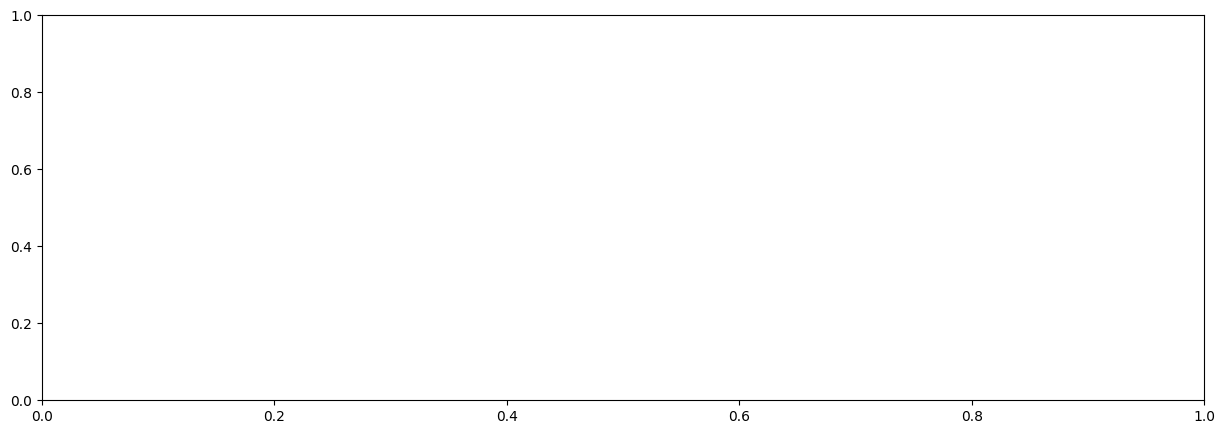

In [ ]:
from src.oced.visualization import plot_activity_bouts

# Define colors for different activity classes
colors = {
    'LIGHT': 'lightgreen',
    'MVPA': 'darkgreen'
}

# Create a dictionary of bout DataFrames
bouts_dfs = {
    'LIGHT': LIGHT_bouts_df,  # Your DataFrame with light activity bouts
    'MVPA': MVPA_bouts_df    # Your DataFrame with MVPA bouts
}

# Plot the bouts
fig, ax = plot_activity_bouts(
    smoothed_df=smoothed_df,
    bouts_dfs=bouts_dfs,
    start_time_column='start_time',
    end_time_column='end_time',
    activity_classes=['LIGHT', 'MVPA'],
    colors=colors,
    figsize=(15, 5),
    title="Physical Activity Bouts"
)

# If you want to show the plot
plt.show()